In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from ipywidgets import interact, SelectionSlider, IntSlider

import metadata_util

In [2]:
import sys
sys.path.append("../../GEOSChem/KPP4GC/GC_12_Standard/") # dirty fix to allow importing
import kpp4py

In [3]:
ds = xr.open_dataset('./KPP_fields_100.nc')

ds_sub = ds.isel(lev=slice(0, 20)).stack(sample=('lev', 'lat', 'lon')).transpose()
ds_sub

<xarray.Dataset>
Dimensions:   (nphotol: 130, nphy: 4, nreact: 725, nspec: 240, sample: 66240)
Coordinates:
  * sample    (sample) MultiIndex
  - lev       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - lat       (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - lon       (sample) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Dimensions without coordinates: nphotol, nphy, nreact, nspec
Data variables:
    C_before  (sample, nspec) float64 5.722e+03 1.662e+06 1.446e+05 ...
    C_after   (sample, nspec) float64 5.722e+03 1.662e+06 1.446e+05 ...
    PHOTOL    (sample, nphotol) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PHY       (sample, nphy) float64 203.3 703.9 2.508e+19 1.243e+14 203.3 ...
    RCONST    (sample, nreact) float64 1.872e-15 1.668e-14 8.976e-16 ...

In [4]:
random_idx = np.random.randint(ds_sub.dims['sample'])
ds_one = ds_sub.isel(sample=random_idx)
ds_one 

<xarray.Dataset>
Dimensions:   (nphotol: 130, nphy: 4, nreact: 725, nspec: 240)
Coordinates:
    sample    object (13, 41, 36)
Dimensions without coordinates: nphotol, nphy, nreact, nspec
Data variables:
    C_before  (nspec) float64 3.77e-14 9.299e-09 4.61e-10 2.536e+06 0.0 ...
    C_after   (nspec) float64 -7.709e-18 8.239e-09 2.925e-10 2.536e+06 ...
    PHOTOL    (nphotol) float64 7.148e-27 0.0003879 1.837e-06 0.0 0.0 ...
    PHY       (nphy) float64 269.4 796.6 2.134e+19 9.644e+16
    RCONST    (nreact) float64 1.145e-14 5.187e-14 1.622e-15 1.346e-17 ...

In [5]:
ref_c_before = ds_one['C_before'].values
ref_phy = ds_one['PHY'].values
ref_photol = ds_one['PHOTOL'].values

ref_c_before.shape, ref_phy.shape, ref_photol.shape

((240,), (4,), (130,))

In [6]:
ref_features = np.r_[ref_c_before, ref_phy, ref_photol]
ref_features.shape

(374,)

In [7]:
ref_c_after = kpp4py.onestep(ref_c_before, ref_phy, ref_photol)
ref_c_after.shape

(240, 1)

In [8]:
n_c = ref_c_before.shape[0]
n_phy = ref_phy.shape[0]
n_jv = ref_photol.shape[0]

n_features = n_c + n_phy + n_jv
n_features

374

In [9]:
dr = 0.2 # perturb ratio

perturb_features = np.empty([n_features, n_features])

perturb_features[:] = ref_features
for i in range(n_features):
    perturb_features[i, i] *= (1.0+dr)

In [10]:
%%time
perturb_c_after = kpp4py.onestep(perturb_features[:,0:n_c].T, 
                                 perturb_features[:,n_c:n_c+n_phy].T, 
                                 perturb_features[:,n_c+n_phy:].T)
print(perturb_c_after.shape)

(240, 374)
CPU times: user 320 ms, sys: 3.28 ms, total: 323 ms
Wall time: 322 ms


In [11]:
A = (perturb_c_after/ref_c_after - 1)/dr # sensitivity matrix (relative change)
A.shape

/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(240, 374)

Text(0.5,1,'sensitivity matrix')

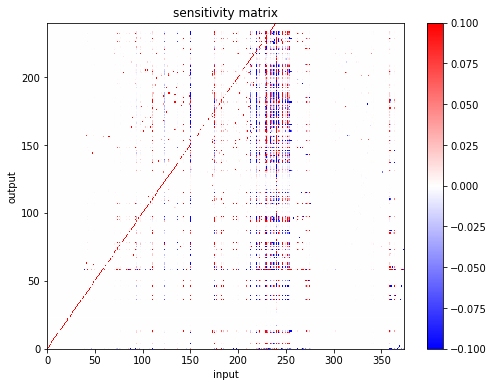

In [12]:
plt.figure(figsize=[8, 6])
plt.pcolormesh(A, cmap='bwr', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.ylabel('output')
plt.xlabel('input')
plt.title('sensitivity matrix')

In [13]:
feature_importance = (np.abs(A) > 0.1).sum(axis=0)
feature_importance

/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([  1,   1,   1,   1,   0,   1,   1,   1,   1,   1,   1,   1,   0,
         0,   1,   1,   1,   1,   1,   1,   1,   1,   0,   0,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   0,   1,   1,
         0,   1,   2,   2,   1,   1,   1,   0,   2,   2,   2,   0,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   0,   1,   0,   0,   2,
         2,   1,   0,   1,   0,   1,   1,   1,   1,   3,   0,   2,   0,
         0,   1,   2,   1,   1,   2,   1,   1,   2,   2,   2,   2,   2,
         1,  11,   1,   0,   1,   1,   1,   2,   1,   2,   2,   1,   2,
         1,   2,   2,   0,   4,   0,  23,   1,   0,   1,   3,   0,   1,
         2,   1,   1,   1,   1,   3,   5,   1,   3,   1,   4,   2,   1,
         1,   1,   2,   5,   4,   2,   4,  13,   0,   0,   2,   2,   0,
        19,   0,   1,   1,   1,   1,   2,  57,   0,   0,   0,   0,   0,
         0,   1,   1,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,
         1,   0,   0,   0,   9,   0,  27,   0,   3,   0,   0,   

In [14]:
df_importance = pd.Series(feature_importance, 
                          index = metadata_util.read_spec_names() + 
                          metadata_util.get_phy_names() + 
                          metadata_util.read_jval_names())

In [15]:
df_importance.nlargest(40)

TEMP               120
O3                  85
CO                  62
H2O                 59
CH4                 57
NUMDEN              56
NO2                 54
3/O3/O3(1D)         53
9/H2O2/H2O2         48
11/NO2/NO2          38
N2                  37
H2O2                27
NO                  27
HOI                 23
116/HOI/HOI         22
CH2O                21
BrNO3               19
IO                  15
IONO2               13
7/CH2O/H2COa        13
HOBr                12
29/BrNO3/BrNO3      12
32/HOBr/HOBr        12
CH3Cl               11
HOCl                11
ClNO3               11
24/HOCl/HOCl        11
12/NO3/NO3          10
117/IO/IO           10
ISOP                 9
BrO                  9
HCl                  9
19/ClNO3/ClNO3a      9
O2                   7
13/NO3/NO3           7
121/IONO2/IONO2      6
MP                   5
MTPA                 5
ISN1                 5
PRPE                 5
dtype: int64

In [16]:
input_dependence = (np.abs(A) > 0.1).sum(axis=1)
input_dependence

/Users/zhuangjw/Research/Computing/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([17,  1,  2,  1, 11,  1,  1,  1,  1,  1,  1,  1, 13, 13,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 29,  1,  1, 19,  1,  1,  1,  1,  1,  1, 26,  2,  2,  1, 13,
        1,  1,  1,  1,  1,  1,  1, 73,  1, 13,  1, 10, 11,  1,  1,  1,  7,
        1, 10,  1,  2,  1, 19,  1,  8,  1, 14, 22,  1,  2,  1,  2,  1,  1,
       11,  1, 20,  1,  1,  1,  1,  1,  1, 13, 17, 15, 21,  2,  2,  1,  2,
        1,  1,  1,  1,  2, 20,  1,  9,  5,  1, 10,  1,  1, 12,  1,  2,  1,
        1,  2,  1,  1,  2,  1,  2,  1,  2,  2,  1,  1,  7,  2,  3,  3,  2,
        1, 11,  9,  8,  2,  3, 14, 11,  4,  1, 22,  1, 16,  1,  1, 10,  4,
       19,  5,  4, 11,  2,  1,  4,  9,  6,  4, 11,  1, 19, 12, 11,  9,  1,
       11,  4, 13,  2, 10,  1, 12,  7,  7,  7,  2, 23, 23,  5, 10,  8, 10,
       10, 12,  1,  2,  1, 13,  2, 10,  3,  5,  2,  2,  4,  1,  3,  9, 12,
       13, 14,  1,  1, 13,  8,  1,  2,  1,  2,  1,  2,  1,  7,  1,  1, 13,
        9,  5,  1,  1,  5

In [17]:
df_dependence = pd.Series(input_dependence, 
                          index = metadata_util.read_spec_names()
                         )

In [18]:
df_dependence.nlargest(40)  # this depends greatly on particular sample!

IBr         73
I2O4        29
I2O3        26
OLND        23
OLNN        23
Cl2O2       22
I2          22
OClO        21
OIO         20
BrCl        20
I2O2        19
ICl         19
ISNOOB      19
MAN2        19
CH2I2       17
ClOO        17
Cl2         16
Cl          16
HNO2        15
MPN         14
H           14
R4O2        14
ClO         14
LISOPOH     13
LISOPNO3    13
BrNO2       13
INO         13
HNO4        13
R4N1        13
NMAO3       13
INO2        13
MRO2        13
MO2         13
Br2         12
ISNOOA      12
ATO2        12
HC5OO       12
ETO2        12
OH          12
CO2         11
dtype: int64